## Libraries importing

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
print("Libraries imported")

Libraries imported


## Data loading

In [97]:
df = pd.read_csv('data/heart_disease.csv')
X = df.drop(columns='num')
y = df['num']
print("Data loaded")
print(df.describe())

Data loaded
               ca        thal         age         sex          cp    trestbps  \
count  302.000000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean     0.665563    4.715232   -0.004609    0.682119    3.158940    0.003145   
std      0.935142    1.937143    1.000093    0.466426    0.961676    1.001817   
min      0.000000    3.000000   -2.819115    0.000000    1.000000   -2.145037   
25%      0.000000    3.000000   -0.713556    0.000000    3.000000   -0.665300   
50%      0.000000    3.000000    0.117585    1.000000    3.000000   -0.096170   
75%      1.000000    7.000000    0.727089    1.000000    4.000000    0.472960   
max      3.000000    7.000000    2.500191    1.000000    4.000000    3.887739   

             chol         fbs     restecg     thalach       exang     oldpeak  \
count  302.000000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean    -0.020326    0.149007    0.986755   -0.001507    0.327815   -0.001601   
std      0.9386

## Model fitting

In [98]:
random_forest = RandomForestClassifier(n_estimators=1500, random_state=30)
random_forest.fit(X, y)

,n_estimators,1500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Getting feature importantances and visualizing it

In [99]:
importances = random_forest.feature_importances_
features = X.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)
feature_importances

,Feature,Importance
9,thalach,0.133863
11,oldpeak,0.120220
6,chol,0.118261
2,age,0.108849
5,trestbps,0.099054
0,ca,0.097046
1,thal,0.082598
4,cp,0.077879
10,exang,0.044106
12,slope,0.042489


<Axes: title={'center': 'Feature Importance'}, xlabel='Feature', ylabel='Importance'>

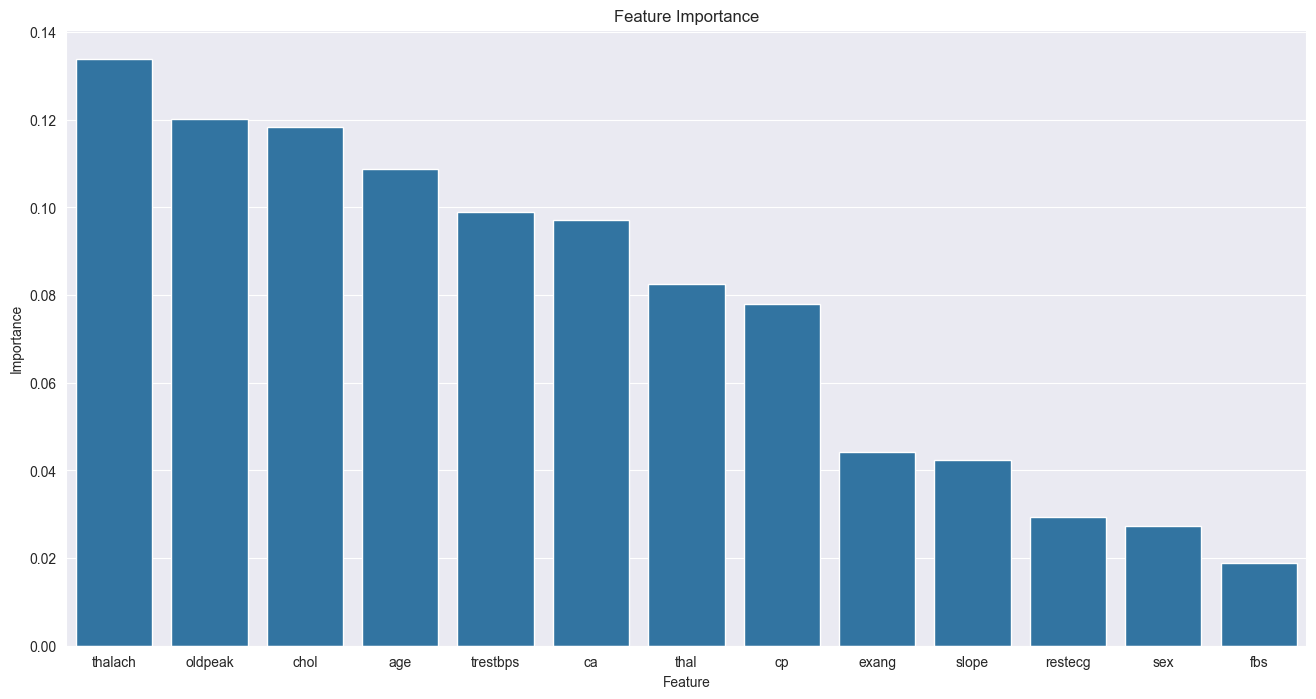

In [100]:
plt.figure(figsize=(16, 8))
plt.title("Feature Importance random forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
sns.barplot(x='Feature', y='Importance', data=feature_importances)

## Recursive feature elimination results

In [116]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=11)
rfe.fit(X, y)
rfe_results = rfe.support_
rfe_df = pd.DataFrame({'X': X.columns, 'RFE': rfe_results, 'Score': rfe.ranking_}).sort_values('Score', ascending=True)
rfe_df

,X,RFE,Score
0,ca,True,1
1,thal,True,1
2,age,True,1
4,cp,True,1
6,chol,True,1
5,trestbps,True,1
11,oldpeak,True,1
9,thalach,True,1
12,slope,True,1
10,exang,False,2


### CHI2 score with visualization

<Axes: xlabel='X', ylabel='Chi-square'>

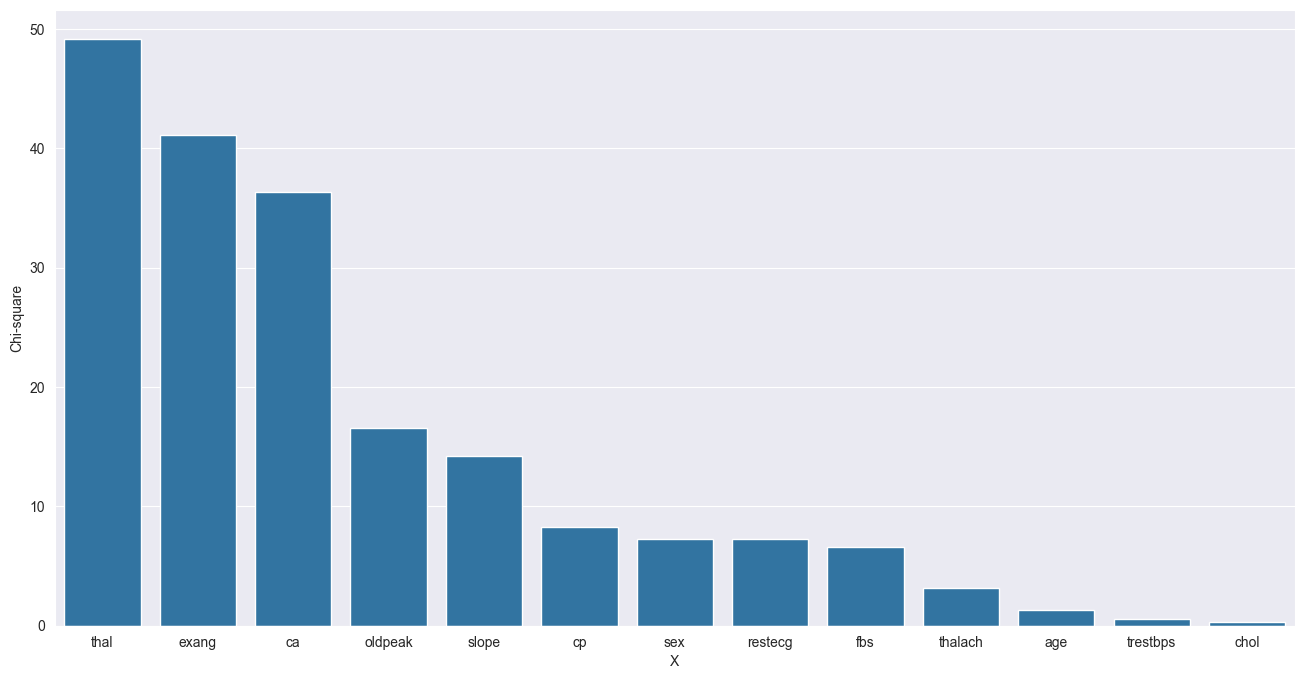

In [102]:
#rescale the data to remove the negatives
scaler = MinMaxScaler()
X_no_negatives = scaler.fit_transform(X)
chi2_selector = SelectKBest(score_func=chi2, k=11)
chi2_selector.fit(X_no_negatives, y)
chi2_scores = pd.DataFrame({'X': X.columns, 'Chi-square': chi2_selector.scores_}).sort_values('Chi-square', ascending=False)
plt.figure(figsize=(16, 8))
sns.barplot(x='X', y='Chi-square', data=chi2_scores)

## Turning the dataframes to sets in order to find intersections

In [103]:
selected_features_chi2 = pd.DataFrame( X.columns[chi2_selector.get_support()])
selected_features_chi2 = set(selected_features_chi2[selected_features_chi2.columns[0]].tolist())
selected_features_chi2

{'age',
 'ca',
 'cp',
 'exang',
 'fbs',
 'oldpeak',
 'restecg',
 'sex',
 'slope',
 'thal',
 'thalach'}

In [104]:
Random_forest_selected = feature_importances[feature_importances.Importance > 0.029].Feature
Random_forest_selected = set(Random_forest_selected.tolist())
Random_forest_selected

{'age',
 'ca',
 'chol',
 'cp',
 'exang',
 'oldpeak',
 'restecg',
 'slope',
 'thal',
 'thalach',
 'trestbps'}

In [105]:
rfe_selected_columns = rfe_df[rfe_df.RFE == 1].X
rfe_selected_columns = set(rfe_selected_columns.tolist())
rfe_selected_columns

{'age',
 'ca',
 'chol',
 'cp',
 'exang',
 'fbs',
 'oldpeak',
 'slope',
 'thal',
 'thalach',
 'trestbps'}

## Final Selected Features

In [106]:
final_columns = []
for col in X.columns:
    if col in Random_forest_selected and col  in rfe_selected_columns and col  in selected_features_chi2:
        final_columns.append(col)
final_columns

['ca', 'thal', 'age', 'cp', 'thalach', 'exang', 'oldpeak', 'slope']

In [110]:
final_X = X[final_columns]
final_X

,ca,thal,age,cp,thalach,exang,oldpeak,slope
0,0,6,0.948726,1,0.017197,0,1.087338,3
1,3,3,1.392002,4,-1.821905,1,0.397182,2
2,2,7,1.392002,4,-0.902354,1,1.346147,2
3,0,3,-1.932564,3,1.637359,0,2.122573,3
4,0,3,-1.489288,2,0.980537,0,0.310912,1
...,...,...,...,...,...,...,...,...
297,0,7,-1.046013,1,-0.770990,0,0.138373,2
298,2,7,1.502821,4,-0.376896,0,2.036303,2
299,1,7,0.283813,4,-1.515388,1,0.138373,2
300,1,3,0.283813,2,1.068113,0,-0.896862,2
